In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b


Using TensorFlow backend.


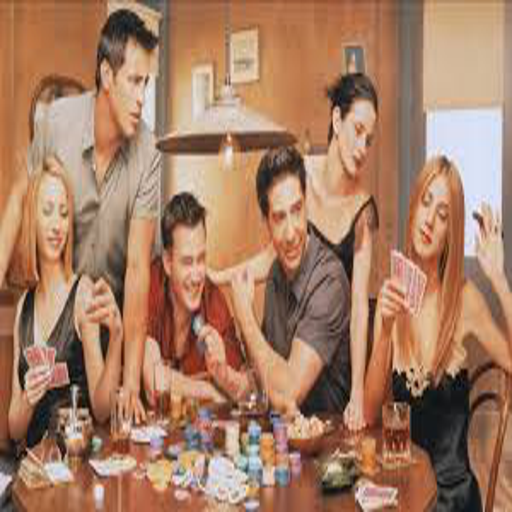

In [2]:
height = 512
width = 512

#Enter the path of content image i.e. image you would like the characteristics to be transferred to. 
content_image_path = '/content/friends.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

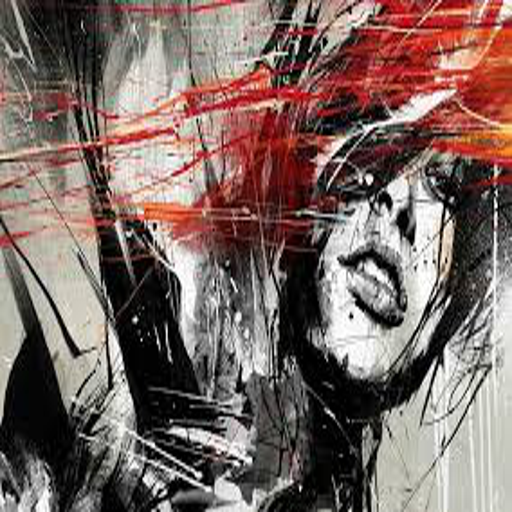

In [3]:
#Enter the path of style image i.e. image you would like to use as your style.
style_image_path = '/content/images.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [4]:
#Convert images to 4_D array
content_array = np.asarray(content_image, dtype= 'float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

(1, 512, 512, 3)


In [5]:
style_array = np.asarray(style_image, dtype= 'float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)


In [6]:
#1) Subtract the mean RGB value from each channel in the input
#2) Flip the multidimensional array from RGB to BGR

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [7]:
#Defining variables in keras backend-->tensorflow
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

#Concatenate all image data into a single tensor
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis = 0)

#model object without the top layers/fully connected layers
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)

layers = dict([(layer.name, layer.output) for layer in model.layers])

58892288/58889256 [==============================] - 5s 0us/step


In [8]:
#Defining alpha and beta hyperparameters
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

loss = backend.variable(0.)

#The content loss
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [9]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features, combination_features)

In [10]:
#The style loss
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [11]:
#VGG16 layers used
feature_layers = ['block1_conv2', 'block2_conv2', 
                  'block3_conv3', 'block4_conv3', 
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, : ,: ,:]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [12]:
loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

In [13]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


In [14]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [15]:
evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 8

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 87408070000.0
Iteration 0 completed in 458s
Start of iteration 1
Current loss value: 43696718000.0
Iteration 1 completed in 458s
Start of iteration 2
Current loss value: 28708565000.0
Iteration 2 completed in 454s
Start of iteration 3
Current loss value: 22766576000.0
Iteration 3 completed in 458s
Start of iteration 4
Current loss value: 20104747000.0
Iteration 4 completed in 456s
Start of iteration 5
Current loss value: 18766990000.0
Iteration 5 completed in 457s
Start of iteration 6
Current loss value: 18081640000.0
Iteration 6 completed in 453s
Start of iteration 7
Current loss value: 17682747000.0
Iteration 7 completed in 459s


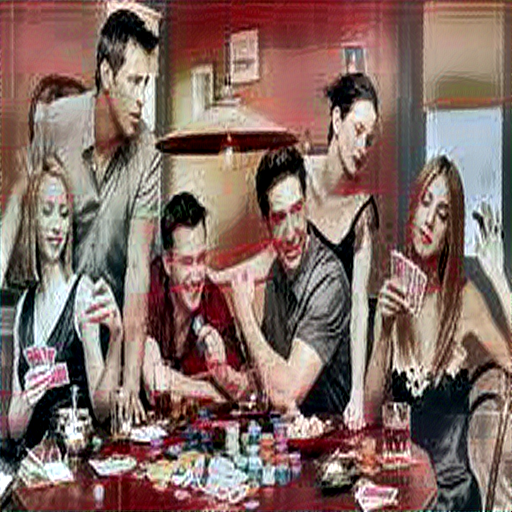

In [16]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)